[Yazı dizimizin bir önceki bölümünde](http://www.veridefteri.com/2019/03/01/bilimsel-programlamaya-kolay-baslangic-iii/) `numpy` kullanımına basit bir giriş yapmıştık, şimdi ise daha ileri matematiksel yöntemleri içeren `scipy`'a bir göz atalım. Yapmaya çalıştığımız "ivmenin nümerik integrasyonu" işi, aslında bir "ikinci derece diferansiyel denklem çözümü" ile eşdeğer. Konumun zamana göre ikinci türevi olan ivme diferansiyel denklemini analitik olarak çözebilseydik, konum ve hız vektörlerinin geçmiş ve gelecekteki tüm değerlerini bulabilirdik. Lakin bunu analitik olarak çözmeye hiç niyetimiz yok - işi bilgisayar yapabilecekken biz niye uğraşalım ki?

`scipy` bu tür diferansiyel denklemleri çözmek için bize `integrate` paketi altında `solve_ivp` adlı kütüphaneyi sunuyor. Bu kütüphane altındaki metodlarla diferansiyel denklemleri sayısal metodlarla kolayca çözebiliriz. Ancak öncelikle denklemleri bu yöntemlerin anlayacağı halde yazmamız gerekiyor, diğer bir deyişle ikinci derece diferansiyel denklemi iki tane birinci derece diferansiyel denklem haline getirmemiz gerekiyor. Öncelikle kullanacağımız ara değişkenleri belirleyelim:

$$\vec{y_1} = \frac{d\vec{r}}{dt} = \dot{\vec{r}}$$
$$\vec{y_2} = \vec{r}$$

Şimdi de ikinci derece diferansiyel denklemimizi bu yeni değişkenler cinsinden yazalım:  
$$\dot{\vec{y_2}} = \frac{d\vec{y_2}}{dt} = \vec{y_1}$$  
$$\dot{\vec{y_1}} = \frac{d\vec{y_1}}{dt} = - \frac{\mu}{(y_2)^3} \vec{y_2}$$

Böylece ikinci derece diferansiyel denklemimiz iki tane birinci derece diferansiyel denkleme indirgendi ve `scipy`'ın çözebileceği hale geldi.

Yukarıda olan biteni kod halinde yazmak zor değil:

In [25]:
import numpy as np
from scipy.integrate import solve_ivp

# Kütleçekimi Sabiti [m^3/s^2]
muDünya = 398600.5*1E9  

def odeDiffDenklem(t, y, mu=muDünya):
    """
    İki cisim problemi için diferansiyel denklem setini tanımlar.
    
    Arguments:
        t {float} -- başlangıç zamanı (s)
        y {ndarray} -- konum (m) ve hızı (m/s) içeren 1B, 4 elemanlı vektör [r_x r_y v_x v_y]


    Returns:
        {ndarray} -- konum ve hız diferansiyel denklemlerini (hız (m/s) ve ivmeyi(m/s^2)) içeren 
        1B, 4 elemanlı vektör [v_x v_y a_x a_y]
    """
    r = np.sqrt(y[0]**2 + y[1]**2)

    dy0 = y[2]
    dy1 = y[3]
    dy2 = -(mu / (r**3)) * y[0]
    dy3 = -(mu / (r**3)) * y[1]
    
    return [dy0, dy1, dy2, dy3]

`odeDiffDenklem` zaman ile konum-hız vektörünü alıyor (aslında yerçekimi ivmesini de alıyor ama maalesef henüz yeni çıkmış olan `solve_ivp` paketi bu değerin dışarıdan atanmasını kabul etmiyor).

Yukarıdaki metodla tanımlanan diferansiyel denklem setini çözen kod da zor görünüyor, ama aslında değil:

In [26]:

def odeÇözümü(pvt0, tAdım, tSon, çözücüTipi = 'RK45'):
    """
    Scipy ODE sayısal integrasyon metodlarıyla konum ve hız değerleri listesini hesaplar.

    Arguments:
        tAdım {float} -- adım büyüklüğü (s)
        pvt0 {ZamanKonumHız} -- başlangıç zamanında zaman konum hız
        tSon {float} -- bitiş zamanı (s)
        çözücüTipi {string} -- ODE çözücüsünün tipi ('RK45', 'RK23', 'Radau', 'BDF', 'LSODA')

    Returns:
        list {ZamanKonumHız} --  her bir zaman adımı için zaman konum hız değerlerini içeren liste
    """

    # adımSayısı ve zaman listesini oluştur
    adımSayısı = (tSon-pvt0.t)/tAdım + 1
    zamanListesi = np.asarray(np.linspace(pvt0.t, tSon, num = adımSayısı, endpoint=True))
    
    # diff denklem başlangıç değerlerini oluştur
    diffIlkDeğer = np.asarray(np.concatenate([pvt0.r, pvt0.v]))
    
    # diff denklemi başlangıç zamanından son zamana dek çöz
    diffDenkÇözüm = solve_ivp(odeDiffDenklem, [pvt0.t, tSon], diffIlkDeğer, method=çözücüTipi, dense_output=True) 
    
    # zaman listesine karşılık gelen değerleri oluştur
    cozumListesi = diffDenkÇözüm.sol.__call__(zamanListesi)
    
    # sonuç listesini başlat
    numPvtList = []

    # Listeyi objelere dönştür
    for i in range(len(zamanListesi)):
        pvArray = cozumListesi[:, i]
        numPvtList.append( ZamanKonumHız(zamanListesi[i], pvArray[0], pvArray[1], pvArray[2], pvArray[3]) )

    return (numPvtList)

`odeÇözümü`, başlangıç ZamanKonumHız nesnesini, adım büyüklüğünü ve son zaman adımını alıyor. Buraya kadarki kısmı Euler ile benzer. Ancak buna ek olarak kullanılacak diferansiyel denklem çözüm yöntemini de alıyor. Varsayılan değer olan `RK45`, 4. derece bir çözücü kullanarak adım büyüklüğünü belirleyen ama asıl çözüm için 5. derece kullanan bir _Adaptif Runge-Kutta_ yöntemi. Çok profesyonel olmasa da birçok öğrencinin projelerinde iş görecek bir diferansiyel denklem çözücüsü. Bu yöntem, hatayı belli bir seviyenin altında tutacak şekilde kendi adım büyüklüğünü belirleyecek kadar da akıllı. Ancak biz her `tAdım` değerinde bir çıktı almak istiyoruz. Bu nedenle, her `tAdım` aralıkla çıktı alınacak zamanların bir listesini oluşturuyoruz.

`solve_ivp` satırı aslında denklem setinin çözüldüğü satır - bir döngü bile yok, her şey sessiz sedasız içeride hallediliyor. Bu çözücüye diferansiyel denklem setini içeren metodu, başlangıç ve bitiş zamanlarını, ilk konum ve hızı ve çözücü tipini yolluyoruz. Bir sonraki adımda ise zaman listesine karşılık gelen ara çözümleri oluşturuyoruz. Biz `diffDenkÇözüm.sol.__call__(zamanListesi)` komutunu yazdığımızda arka tarafta interpolasyon algoritmaları bizim istediğimiz zamanlara karşılık gelen noktaları oluşturuyor. Son kısımda ise elde ettiğimiz bu çözüm setini `ZamanKonumHız` nesnelerine dolduruyoruz.

Sadece bu iki satır ile, oturup yazmaya üşeneceğimiz (ben benzerlerini yazdım, oradan biliyorum), yüzlerce satırlık koda karşılık gelen işlevselliği kolaylıkla elde edebiliyoruz. `scipy` sayesinde elbette!

O halde bunları çağırarak problemi çözen koda bakalım:

In [27]:
# başlangıç zamanı
t0 = 0
# bitiş zamanı (sn)
tSon = 6000 
# adım büyüklüğü (sn)
tAdımEuler_1  = 5
tAdımEuler_2  = 1
tAdımODE = 60
çözücüTipi = 'RK23'

# başlangıç konum ve hız
pvt0 = ZamanKonumHız(t0, 0, 7000*1E3, 7.5*1E3, 0)


# Euler sayısal integrasyon verisini hesaplayan döngüyü çalıştır
eulPvtList5  = hesapDöngüsüEuler(pvt0, tAdımEuler_1, tSon)
eulPvtList1  = hesapDöngüsüEuler(pvt0, tAdımEuler_2, tSon)

çözücüPvtList = odeÇözümü(pvt0, tAdımODE, tSon, çözücüTipi)

/home/egemen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


Diferansiyel denklem çözücüsü için 60 saniyelik bir çıktı adım büyüklüğü kullandık, ama bu seferlik kullanacağımız 3. derece Runge-Kutta (`RK23`) yönteminde de adım büyüklüğü otomatik olarak, integrasyon algoritması tarafından belirleniyor. Bakalım `RK23` kullanarak bulduğumuz sonuçlar küçük adımlara sahip Euler yöntemlerinden daha mı iyi çıkacak? 

Bu sorunun yanıtı için grafikleri oluşturmamız gerek:

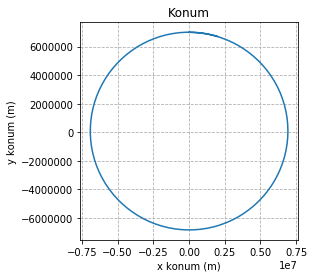

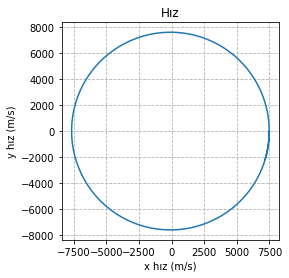

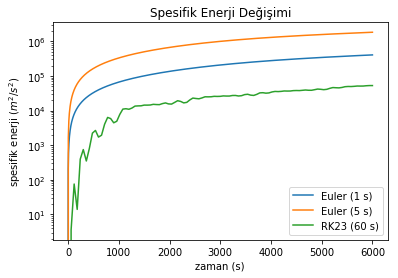

In [28]:
# konum grafiği
plt.plot( [pvt.r[0] for pvt in çözücüPvtList], [pvt.r[1] for pvt in çözücüPvtList], label=çözücüTipi + " (" + str(tAdımODE) + " s)")

plt.title("Konum")
plt.xlabel("x konum (m)")
plt.ylabel('y konum (m)')

plt.axes().set_aspect('equal')
plt.grid(b=True, which='major', linestyle='--')

plt.show()

# hız grafiği
plt.plot( [pvt.v[0] for pvt in çözücüPvtList], [pvt.v[1] for pvt in çözücüPvtList], label=çözücüTipi + " (" + str(tAdımODE) + " s)")

plt.title("Hız")
plt.xlabel("x hız (m/s)")
plt.ylabel("y hız (m/s)")

plt.axes().set_aspect('equal')
plt.grid(b=True, which='major', linestyle='--')

plt.show() 

# enerji grafikleri

#referans değer - tüm farklar bu değere göre hesaplanacak
spEnerjiRef = pvt0.spesifikEnerji()

plt.title("Spesifik Enerji Değişimi")
plt.xlabel("zaman (s)")
plt.ylabel("spesifik enerji ($m^2/s^2$)")
plt.yscale('log')

plt.plot( [pvt.t for pvt in eulPvtList1], [np.abs(pvt.spesifikEnerji()-spEnerjiRef) for pvt in eulPvtList1], label="Euler (" + str(tAdımEuler_2) + " s)")
plt.plot( [pvt.t for pvt in eulPvtList5], [np.abs(pvt.spesifikEnerji()-spEnerjiRef) for pvt in eulPvtList5], label="Euler (" + str(tAdımEuler_1) + " s)")
plt.plot( [pvt.t for pvt in çözücüPvtList], [np.abs(pvt.spesifikEnerji()-spEnerjiRef) for pvt in çözücüPvtList], label=çözücüTipi + " (" + str(tAdımODE) + " s)")

plt.legend(loc=4)

plt.show()

Öncelikle konum ve hız grafiklerini göstermek için kullandığımız RK23'ün hiç fena performans göstermediği anlaşılıyor - başladığımız yere iyi kötü dönmeyi başarmışız.

Yöntemler arasındaki uçurum nedeniyle enerji değişim grafiğini log ölçeğinde çizdirdik, aslında tüm yöntemler için artış lineer. Log kısmını kapatıp bunu siz de görebilirsiniz. Enerji grafiklerine bakınca, `RK23`'ün, 1 saniye adım büyüklüğüne sahip Euler'in sadece onda biri kadar enerji hatası yaptığı görülüyor. Yani `scipy`'ın yöntemleri bizim uzun uzadıya yazdığımız kodlardan çok daha iyi sonuç veriyor. Çıkarılacak sonuç çok açık, tekerleği yeniden keşfetmenin gereği yok - tabii `scipy`'ın sunduklarından daha iyi algoritmalar kullanmak durumundaysanız iş başka.

Yazdığımız `odeÇözümü` metodunda pek hoş olmayan bir kısım var: metoda çözücü adını `string` olarak yolluyoruz. Ancak kafamıza göre bir string değeri yollamamız mümkün değil, zira `solve_ivp` tarafından kabul edilen sadece birkaç çözücü var. Bu yöntem bizi hataya fazlasıyla açık hale getiriyor. Bunu çözmenin pratik bir yolu `enumerator` adı verilen mini mini veri depoları. Öncelikle enum içinde olası tüm değerleri (yani integrasyon algoritması tiplerini) belirliyoruz. Örneğin _adı_, yani `çözücüTipi.name` değeri RADAU olan bir parametremiz var. Bunun `çözücüTipi.value` ile sorgulanan _değeri_ 'Radau' ile ifade edilen string. Böylece parametre adları ve buna karşılık gelen değerlerden mini bir tablo oluşturmuş oluyoruz.

In [29]:
from enum import Enum

class ODEÇözücüTipi(Enum):
    """
    solve_ivp integrasyon tipleri
    """
    RK45 = 'RK45'
    RK23 = 'RK23'
    RADAU = 'Radau'
    BDF = 'BDF'
    LSODA = 'LSODA'

Bir sonraki adımda da `odeÇözümü` metodunda buna uygun küçük bir değişiklik yapıyoruz - metodumuzun kullanıcısını yukarıda belirlediğimiz tablodaki parametreler arasında bir tercih yapmaya zorluyoruz. 

In [30]:
def odeÇözümü(pvt0, tAdım, tSon, çözücüTipi = ODEÇözücüTipi.RK45):
    """
    Scipy ODE sayısal integrasyon metodlarıyla konum ve hız değerleri listesini hesaplar.

    Arguments:
        tAdım {float} -- adım büyüklüğü (s)
        pvt0 {ZamanKonumHız} -- başlangıç zamanında zaman konum hız
        tSon {float} -- bitiş zamanı (s)
        çözücüTipi {ODEÇözücüTipi} -- ODE Çözücü Tipi

    Returns:
        list {ZamanKonumHız} --  her bir zaman adımı için zaman konum hız değerlerini içeren liste
    """

    # adımSayısı ve zaman listesini oluştur
    adımSayısı = (tSon-pvt0.t)/tAdım + 1
    zamanListesi = np.asarray(np.linspace(pvt0.t, tSon, num = adımSayısı, endpoint=True))
    
    # diff denklem başlangıç değerlerini oluştur
    diffIlkDeğer = np.asarray(np.concatenate([pvt0.r, pvt0.v]))
    
    # diff denklemi başlangıç zamanından son zamana dek çöz
    diffDenkÇözüm = solve_ivp(odeDiffDenklem, [pvt0.t, tSon], diffIlkDeğer, method=çözücüTipi.value, 
                                                                  dense_output=True, rtol = 1e-12, atol = 1e-15) 

    
    # zaman listesine karşılık gelen değerleri oluştur
    cozumListesi = diffDenkÇözüm.sol.__call__(zamanListesi)
    
    # sonuç listesini başlat
    numPvtList = []

    # Listeyi objelere dönştür
    for i in range(len(zamanListesi)):
        pvArray = cozumListesi[:, i]
        numPvtList.append( ZamanKonumHız(zamanListesi[i], pvArray[0], pvArray[1], pvArray[2], pvArray[3]) )

    return (numPvtList)

Burada bir değişiklik daha yaptık ve `solve_ivp`'yi çağırırken `method=çözücüTipi.value, dense_output=True, rtol = 1e-12, atol = 1e-15`  parametre setini de ekledik. Bu üçlünün detaylarına girmeyeceğim, ama sadece hata kontrolünün burada yapıldığını söylemekle yetineyim. Yani buradaki `rtol` ve `atol` ile verilen bağıl ve mutlak tolerans değerlerini ne kadar küçük seçerseniz diferansiyel denklem çözücüsünü de o kadar hatasız ve elbette küçük adımlarla ve yavaş çalışmaya zorlarsınız. Farklı tolerans değerlerini deneyip hatanın nasıl değiştiğini kendiniz de görebilirsiniz. 

Kalan kısımlarda önemli bir değişiklik yapmayacağız, sadece bu kez de RK45 adlı çözücüyü deneyip RK23 ile karşılaştıracağız. Kalan tüm değerler ve Euler ilerleticiler öncekilerle aynı olduğu için buraya eklemedim.

In [31]:
# *********** ana kod yapısı ***********

# başlangıç zamanı
t0 = 0
# bitiş zamanı (sn)
tSon = 6000
# adım büyüklüğü (sn)
tAdımEuler_1  = 5
tAdımEuler_2  = 1
tAdımODE = 60
çözücüTipi1 = ODEÇözücüTipi.RK23
çözücüTipi2 = ODEÇözücüTipi.RK45

# başlangıç konum ve hız
pvt0 = ZamanKonumHız(t0, 0, 7000*1E3, 7.5*1E3, 0)


# Euler sayısal integrasyon verisini hesaplayan döngüyü çalıştır
eulPvtList5  = hesapDöngüsüEuler(pvt0, tAdımEuler_1, tSon)
eulPvtList1  = hesapDöngüsüEuler(pvt0, tAdımEuler_2, tSon)

çözücüPvtList1 = odeÇözümü(pvt0, tAdımODE, tSon, çözücüTipi1)
çözücüPvtList2 = odeÇözümü(pvt0, tAdımODE, tSon, çözücüTipi2)


/home/egemen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


Son olarak, yeni diferansiyel çözücümüz RK45'in sonuçlarını görmek için grafiklere tekrar bakalım:

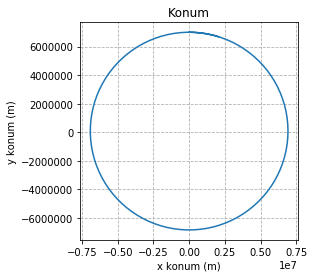

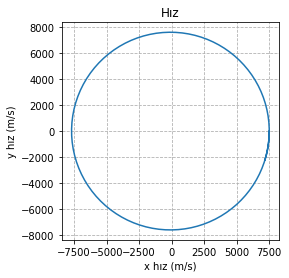

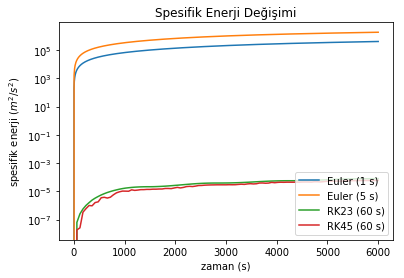

In [32]:
# *********** grafikler ***********

# konum grafiği
plt.plot( [pvt.r[0] for pvt in çözücüPvtList2], [pvt.r[1] for pvt in çözücüPvtList2], label=çözücüTipi2.value + " (" + str(tAdımODE) + " s)")

plt.title("Konum")
plt.xlabel("x konum (m)")
plt.ylabel('y konum (m)')

plt.axes().set_aspect('equal')
plt.grid(b=True, which='major', linestyle='--')

plt.show()

# hız grafiği
plt.plot( [pvt.v[0] for pvt in çözücüPvtList2], [pvt.v[1] for pvt in çözücüPvtList2], label=çözücüTipi2.value + " (" + str(tAdımODE) + " s)")

plt.title("Hız")
plt.xlabel("x hız (m/s)")
plt.ylabel("y hız (m/s)")

plt.axes().set_aspect('equal')
plt.grid(b=True, which='major', linestyle='--')

plt.show() 

# enerji grafikleri

#referans değer - tüm farklar bu değere göre hesaplanacak
spEnerjiRef = pvt0.spesifikEnerji()

plt.title("Spesifik Enerji Değişimi")
plt.xlabel("zaman (s)")
plt.ylabel("spesifik enerji ($m^2/s^2$)")
plt.yscale('log')

plt.plot( [pvt.t for pvt in eulPvtList1], [np.abs(pvt.spesifikEnerji()-spEnerjiRef) for pvt in eulPvtList1], label="Euler (" + str(tAdımEuler_2) + " s)")
plt.plot( [pvt.t for pvt in eulPvtList5], [np.abs(pvt.spesifikEnerji()-spEnerjiRef) for pvt in eulPvtList5], label="Euler (" + str(tAdımEuler_1) + " s)")
plt.plot( [pvt.t for pvt in çözücüPvtList1], [np.abs(pvt.spesifikEnerji()-spEnerjiRef) for pvt in çözücüPvtList1], label=çözücüTipi1.value + " (" + str(tAdımODE) + " s)")
plt.plot( [pvt.t for pvt in çözücüPvtList2], [np.abs(pvt.spesifikEnerji()-spEnerjiRef) for pvt in çözücüPvtList2], label=çözücüTipi2.value + " (" + str(tAdımODE) + " s)")

plt.legend(loc=4)

plt.show()


Standart bir RK23 ile geçen sefer enerjiyi 1 saniye adım büyüklüğüne sahip Euler'den 10 kat daha iyi koruduğumuzu söylemiştik. Bu kez sıkı bir adım kontrolü kullanan bir RK45 ile, Euler'e oranla enerjiyi 10,000,000,000 (10 milyar) kez daha iyi koruduk! Bu kadar iyi bir sonucu elde etmek için daha fazla kod yazmamız da gerekmedi zira `scipy` bize tüm bu imkanları hazır olarak sunuyor. RK23 de RK45'e yakın bir performans gösterdi, çünkü sıkı adım kontrolünü ona da uyguladık. Ancak muhtemelen otomatik seçilen adım büyüklükleri RK45'ten daha küçük kaldı; diğer bir deyişle, kullandığımız metod olan RK23, RK45'ten daha kötü olduğu için aynı performansı gösterebilmek için daha çok çalıştı. Gerçek problemlerde, kullanacağımız sayısal integrasyon metodunun seçimi kritik önem teşkil eder. Diferansiyel denklemin bir adımını çözmek için gereken hesaplama kapasitesi, problemin non-lineerliği ve ne kadar ani değişiklikler gösterdiği, problemi ne kadar uzun süre modelleyeceğimiz ile elbette doğruya ne kadar yakın sonuçlar istediğimize bağlı olarak seçeceğimiz matematiksel model değişiklik gösterir. Bu durumda, genellikle farklı modellerle uzun uzadıya performans testleri yaparak en uygun model seçilir.   

Özetle, bu örneğimizde sonunda `numpy` ve `scipy` kütüphanelerine bir başlangıç yaptık ve kod organizasyonu, işlevlerin ayrılması, kodun yeniden kullanımı gibi yazılımcılık zanaatının temel prensiplerinden bahsettik. Bu arada iki cisim gibi basit bir problemin çözümünde bile, fizik kanunları ve matematiksel modeller arasındaki ilişkinin ne kadar çetrefilli olabileceğine kısaca değindik. Son olarak ikinci derece bir diferansiyel denklemin nasıl çözülebileceğine dair de küçük bir örnek yaptık.

Bu yazıyı da, her zamanki gibi, çalıştırılabilir bir Jupyter defteri halinde, yazıdaki iki örneğin kodlarıyla birlikte GitHub sayfamızda bulabilirsiniz.